# all imports

In [1]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# parameters

In [3]:
# Choose subset of parts to train
keep_parts = slice(10)

epochs = 500 # ctrl-c to stop early
lr = 0.001

seq_len = 50
batch_size = 2

# Increase hidden_dim depending on number of parts being trained
# since it encodes forecast for all parts
hidden_dim = 512
layers = 2

# How many weeks to forecast
predict_steps = 50
# Forecast starts immediately after this slice of data
predict_input = slice(-predict_steps//2)

In [4]:
array = pd.read_csv("order-data.csv", skiprows=[0]).to_numpy()[keep_parts]

# test with sin wave

In [5]:
# Uncomment cell to test predicting sin waves to make sure everything is working...
# epochs = 10000
# lr = .001
# seq_len = 150
# batch_size = 1
# hidden_dim = 128
# layers = 2
# predict_steps = 100
# predict_input = slice(-seq_len, None)
# # Sequence needs to see at least a full wave length or results are bad
# array = np.array([[f'Wave {i}']+[np.sin(x + i*2*np.pi/2)*(i+1) for x in np.linspace(-1000, 1000, 10051)] for i in range(2)])

# transpose data
Extract part name from first column.  Transpose data so each column holds the quantities for a part.

In [6]:
part_names = array.T[0]
floats = np.array(array.T[1:], dtype='float32')
floats.shape

(104, 10)

# normalize quantities to be 0 - 1

In [7]:
min_ = floats.min(0)
max_ = floats.max(0)
normalize   = lambda values: (values - min_) / (max_ - min_)
unnormalize = lambda normalized: normalized * (max_ - min_) + min_

tensor = torch.from_numpy(normalize(floats))

# batch data
Notice how the columns line up. The hidden state output from 0,1,2,3,4 gets fed into sequence 5,6,7,8,9

In [8]:
def batch_data(items, seq_len, batch_size):
    num_batches = (len(items)-1) // (seq_len * batch_size)
    keep = num_batches*seq_len*batch_size
    discard = len(items) - keep - 1
    if discard: print(f"Discarding last {discard} items")
    features = items[:keep]   .view(batch_size, num_batches, seq_len, -1).transpose(0,1).transpose(1,2).to(device)
    targets  = items[1:keep+1].view(batch_size, num_batches, seq_len, -1).transpose(0,1).transpose(1,2).to(device)
    return [*zip(features, targets)]

for x, target in batch_data(torch.tensor(range(31)), seq_len=5, batch_size=3):
    print(x[:,:,0])

tensor([[ 0, 10, 20],
        [ 1, 11, 21],
        [ 2, 12, 22],
        [ 3, 13, 23],
        [ 4, 14, 24]], device='cuda:0')
tensor([[ 5, 15, 25],
        [ 6, 16, 26],
        [ 7, 17, 27],
        [ 8, 18, 28],
        [ 9, 19, 29]], device='cuda:0')


In [9]:
# split = int(tensor.shape[0] * .8)
# train = batch_data(tensor[:split], seq_len, batch_size)
# valid = batch_data(tensor[split:], seq_len, batch_size)

# Until we get more data...
train = valid = batch_data(tensor, seq_len, batch_size)

Discarding last 3 items


# create RNN model
Using LSTM but GRU might be better

In [10]:
class RNN(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layers, dropout=.3)
        self.fc = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(.3)

    def forward(self, x, hidden):
        y, hidden = self.lstm(x, hidden)
        y = y.view(-1, hidden_dim)
        y = self.dropout(y)
        y = self.fc(y)
        return y.view(x.shape), hidden

# define loss and optimizer

In [11]:
model = RNN(tensor.shape[-1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train
Kernal -> Interrupt to end training early

In [12]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    hidden = None
    for x, target in train:
        if hidden:
            hidden = tuple(h.detach() for h in hidden)

        y, hidden = model(x, hidden)
        loss = criterion(y, target)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0
        hidden = None
        for x, target in valid:
            y, hidden = model(x, hidden)
            loss = criterion(y, target)
            valid_loss += loss.item()

    print(f"Epoc {epoch}",
          f"train_loss={round(train_loss*1e5/len(train))}",
          f"valid_loss={round(valid_loss*1e5/len(valid))}")

Epoc 0 train_loss=2357 valid_loss=1944
Epoc 1 train_loss=1947 valid_loss=1917
Epoc 2 train_loss=1955 valid_loss=1903
Epoc 3 train_loss=1915 valid_loss=1864
Epoc 4 train_loss=1863 valid_loss=1859
Epoc 5 train_loss=1860 valid_loss=1862
Epoc 6 train_loss=1850 valid_loss=1860
Epoc 7 train_loss=1872 valid_loss=1850
Epoc 8 train_loss=1849 valid_loss=1837
Epoc 9 train_loss=1848 valid_loss=1824
Epoc 10 train_loss=1816 valid_loss=1814
Epoc 11 train_loss=1834 valid_loss=1807
Epoc 12 train_loss=1811 valid_loss=1799
Epoc 13 train_loss=1813 valid_loss=1788
Epoc 14 train_loss=1800 valid_loss=1775
Epoc 15 train_loss=1781 valid_loss=1759
Epoc 16 train_loss=1770 valid_loss=1742
Epoc 17 train_loss=1744 valid_loss=1723
Epoc 18 train_loss=1727 valid_loss=1701
Epoc 19 train_loss=1714 valid_loss=1677
Epoc 20 train_loss=1690 valid_loss=1649
Epoc 21 train_loss=1639 valid_loss=1616
Epoc 22 train_loss=1628 valid_loss=1580
Epoc 23 train_loss=1605 valid_loss=1541
Epoc 24 train_loss=1559 valid_loss=1502
Epoc 25 tr

Epoc 211 train_loss=255 valid_loss=232
Epoc 212 train_loss=278 valid_loss=233
Epoc 213 train_loss=263 valid_loss=222
Epoc 214 train_loss=267 valid_loss=218
Epoc 215 train_loss=275 valid_loss=215
Epoc 216 train_loss=264 valid_loss=218
Epoc 217 train_loss=296 valid_loss=208
Epoc 218 train_loss=238 valid_loss=200
Epoc 219 train_loss=255 valid_loss=208
Epoc 220 train_loss=257 valid_loss=202
Epoc 221 train_loss=244 valid_loss=202
Epoc 222 train_loss=253 valid_loss=200
Epoc 223 train_loss=248 valid_loss=227
Epoc 224 train_loss=267 valid_loss=198
Epoc 225 train_loss=237 valid_loss=220
Epoc 226 train_loss=271 valid_loss=194
Epoc 227 train_loss=246 valid_loss=205
Epoc 228 train_loss=228 valid_loss=195
Epoc 229 train_loss=244 valid_loss=196
Epoc 230 train_loss=239 valid_loss=215
Epoc 231 train_loss=254 valid_loss=186
Epoc 232 train_loss=233 valid_loss=196
Epoc 233 train_loss=243 valid_loss=214
Epoc 234 train_loss=247 valid_loss=200
Epoc 235 train_loss=257 valid_loss=233
Epoc 236 train_loss=304 v

Epoc 432 train_loss=89 valid_loss=75
Epoc 433 train_loss=107 valid_loss=70
Epoc 434 train_loss=100 valid_loss=68
Epoc 435 train_loss=116 valid_loss=77
Epoc 436 train_loss=130 valid_loss=64
Epoc 437 train_loss=111 valid_loss=79
Epoc 438 train_loss=114 valid_loss=75
Epoc 439 train_loss=112 valid_loss=82
Epoc 440 train_loss=116 valid_loss=69
Epoc 441 train_loss=99 valid_loss=68
Epoc 442 train_loss=94 valid_loss=68
Epoc 443 train_loss=91 valid_loss=73
Epoc 444 train_loss=126 valid_loss=70
Epoc 445 train_loss=108 valid_loss=65
Epoc 446 train_loss=98 valid_loss=67
Epoc 447 train_loss=96 valid_loss=68
Epoc 448 train_loss=100 valid_loss=65
Epoc 449 train_loss=99 valid_loss=72
Epoc 450 train_loss=102 valid_loss=69
Epoc 451 train_loss=109 valid_loss=63
Epoc 452 train_loss=98 valid_loss=66
Epoc 453 train_loss=101 valid_loss=66
Epoc 454 train_loss=87 valid_loss=64
Epoc 455 train_loss=102 valid_loss=65
Epoc 456 train_loss=102 valid_loss=66
Epoc 457 train_loss=87 valid_loss=61
Epoc 458 train_loss=10

# run data through model to create hidden state then generate predictions

In [13]:
input = tensor[predict_input]
sequence = batch_data(input, len(input)-1, 1)
model.eval()
with torch.no_grad():
    x, _ = sequence[0]
    y, hidden = model(x, None)
    y = y[-1:, :, :]
    predict = [y[0,0,:]]
    for i in range(predict_steps):
        y, hidden = model(y, hidden)
        predict.append(y[0,0,:])

# unnormalize data

In [14]:
actual = tensor[predict_input.start:, :]
actual = unnormalize(actual.numpy())
predict = torch.stack(predict)
predict = unnormalize(predict.cpu().numpy())
predict[:,0]

array([-5.3546677e+00, -8.5383177e-01, -4.9227943e+00,  2.2952448e+01,
        4.3479252e+00, -3.8825655e-01,  6.4082932e-01,  2.8887220e+01,
        3.0609343e+01,  2.4246769e+00,  2.8263462e+00, -5.5936301e-01,
        2.6218201e+01,  1.6457531e+00, -1.5842579e-02, -4.0142264e+00,
        2.5771889e+01, -1.0941949e+00, -7.3486406e-01,  5.1721227e-01,
        6.3393230e+00,  1.4009576e+01,  1.4666839e+00,  1.5032598e+00,
        5.2041477e-01,  2.2558865e+01, -8.3999676e-01, -5.4630888e-01,
       -1.1523951e+00,  3.3261063e+01, -1.0812426e+00, -1.0471315e+00,
       -2.0619586e+00,  1.9158562e+01,  1.9433273e+01,  1.4041738e-01,
        2.1419387e+00,  2.1036174e+00,  3.4917603e+01, -2.6375896e-01,
       -6.9917363e-01, -2.5185916e+00,  4.7045242e+01, -1.6694207e+00,
       -1.3114167e+00, -1.9270902e+00,  1.8000622e+01,  3.1242895e+01,
        8.8931578e-01,  1.4989599e+00, -5.2105274e-02], dtype=float32)

# generate plots

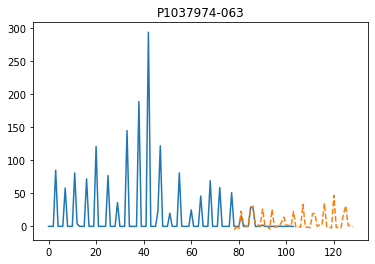

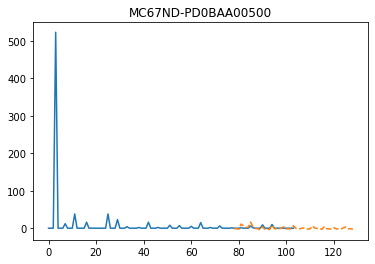

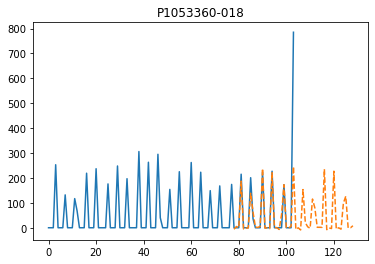

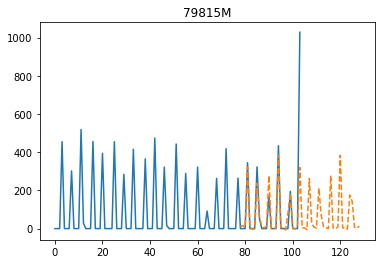

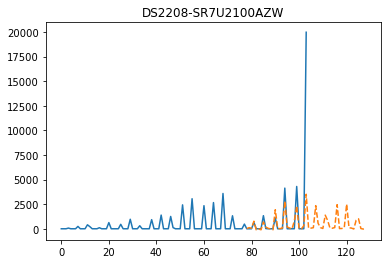

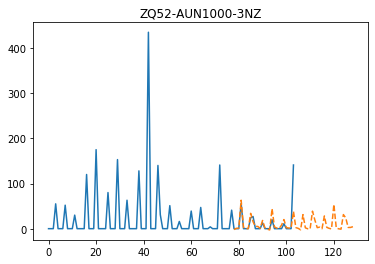

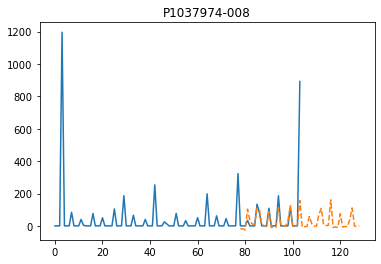

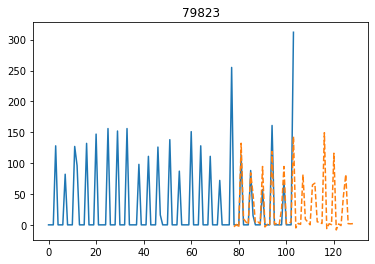

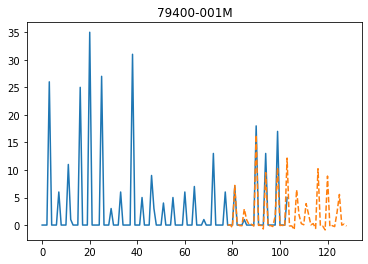

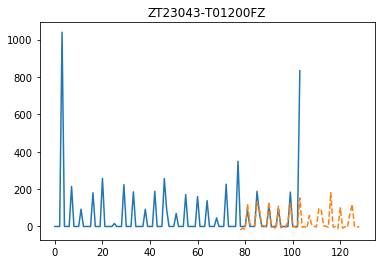

In [15]:
for p in range(actual.shape[1]):
    plt.title(part_names[p])
    act = actual[:, p]
    plt.plot(range(len(act)), act)
    pred = predict[:, p]
    plt.plot(range(len(x), len(x) + len(pred)), pred, linestyle='--')
    plt.show()